# Driven Turbulence with Standard-DG and Rusanov Flux

This notebook describes the "Sedov" blast setup computed with the [FLASH 4.3](http://www.flash.uchicago.edu/site/flashcode).

Setup characteristics:

| term                 | symbol    | value               |
|:-------------------- |:---------:|:-------------------:|
| governing equations  |  --       | compressible Euler  |
| equation of state    |  --       |ideal gas (adiabatic)|
| ambient density      | $\rho_0$  | $1.0$               |
| ambient pressure     | $p_0$     | $10^{-5} \approx 0$ |
| adiabatic const.     | $\gamma$  | $1.4$               |
| initial blast energy | $E_0$     | $1.19025916404$     |
| CFD method           |   --      | Finite-Volume       |
| Riemann Flux         |   --      | Bouchut 5           |
| "FV-equiv." resolution | $N_r$   | 768 x 768           |

# Density and pressure heat maps

In [1]:
import sys
import os
home = os.environ['HOME']
sys.path.append(home + '/projects/turbubox/tools/lib')

import numpy as np
import pandas as pd
import glob
import cubicle

import matplotlib
matplotlib.rcParams.update({'font.size': 9})

import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
def mkplot(fh,gamma=1.4):
    if hasattr(fh, 'gamma'): gamma = fh.gamma
    
    dens = fh.stitch(0,Nvisu=10)
    momx = fh.stitch(1,Nvisu=10)
    momy = fh.stitch(2,Nvisu=10)
    ener = fh.stitch(3,Nvisu=10)

    velx = momx/dens
    vely = momy/dens
    ekin = 0.5*(momx**2+momy**2)/dens
    pres = (gamma-1)*(ener - ekin)
    
    mach = np.sqrt(velx**2+vely**2)/np.sqrt(gamma*pres/dens)

    dpi = 100
    fig = plt.figure(1,figsize=(2*640/dpi, 480/dpi), dpi=dpi)

    plt.xlim(fh.domain.T[0,:])
    plt.ylim(fh.domain.T[1,:])

    plt.subplot(121)

    plt.title('log10 density at time t = {:6.3f}'.format(fh.time))
    plt.imshow(
        np.log10(dens),
        extent = fh.domain.T.ravel(),
        vmin = -2.0,
        vmax =  2.0,
        origin='lower',
        interpolation = None,
        cmap = plt.get_cmap('cubehelix'),
    )
    plt.colorbar()

    plt.subplot(122)
    plt.title('Mach at time t = {:6.3f}'.format(fh.time))

    plt.imshow(
        mach,
        extent = fh.domain.T.ravel(),
        vmin = 0.0,
        vmax = None,
        origin='lower',
        interpolation = None,
        cmap = plt.get_cmap('cubehelix'),
    )
    plt.colorbar()

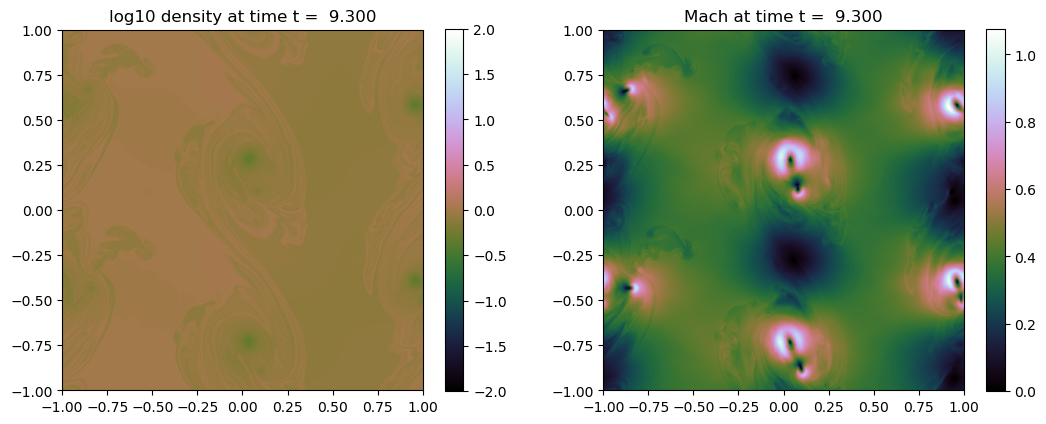

In [60]:
fp = sorted(glob.glob('/mnt/sshfs/cheops/scratch/jmarker2/couchdg/stirturb/div-rusanov/data/chkpt_*.h5'))[-1]
fp = '/mnt/data/couchdg/test/data/chkpt_0050.h5'
fp = '/mnt/sshfs/cheops/scratch/jmarker2/couchdg/KHI/spl-chandrashekar/data/chkpt_0186.h5'
fh = cubicle.File(fp)
mkplot(fh)

In [33]:
fp = '/mnt/sshfs/cheops/scratch/jmarker2/couchdg/stirturb/div-rusanov/data/chkpt_0267.h5'
fh = cubicle.File(fp)

gamma = fh.gamma

dens = fh.stitch(0,Nvisu=10)
momx = fh.stitch(1,Nvisu=10)
momy = fh.stitch(2,Nvisu=10)
ener = fh.stitch(3,Nvisu=10)

velx = momx/dens
vely = momy/dens
ekin = 0.5*(momx**2+momy**2)/dens
pres = (gamma-1)*(ener - ekin)

mach = np.sqrt(np.sum(dens*(velx**2+vely**2))/np.sum(dens)) / np.sqrt(gamma*np.mean(pres)/np.mean(dens))
bulk = np.mean(momx+momy)

print("mach:", mach)
print("bulk:", bulk)

mach: 2.50052585534
bulk: -1.10874015024e-05


## Shell-averaged density and pressure profiles

In [8]:
mkpd_a = lambda fp: pd.read_table(fp, names='nr radius dens ener pres vels sndspd'.split(), sep='\s+')
dirp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/shell-averages/analytic'
analytics = [mkpd_a(fp) for fp in glob.glob(dirp+'/analytical_*.dat')]

In [9]:
mkpd_d = lambda fp: pd.read_table(fp, names='radius dens'.split(), sep='\s+', skiprows=1)
mkpd_p = lambda fp: pd.read_table(fp, names='radius pres'.split(), sep='\s+', skiprows=1)

dirp = '/mnt/sshfs/cheops/scratch/jmarker2/flash/sedov/shell-averages/numeric'
dens = [mkpd_d(fp) for fp in glob.glob(dirp+'/density-*.dat')]
pres = [mkpd_p(fp) for fp in glob.glob(dirp+'/pressure-*.dat')]

numerics = [pd.concat((de,pr.pres),axis=1) for de,pr in zip(dens,pres)]

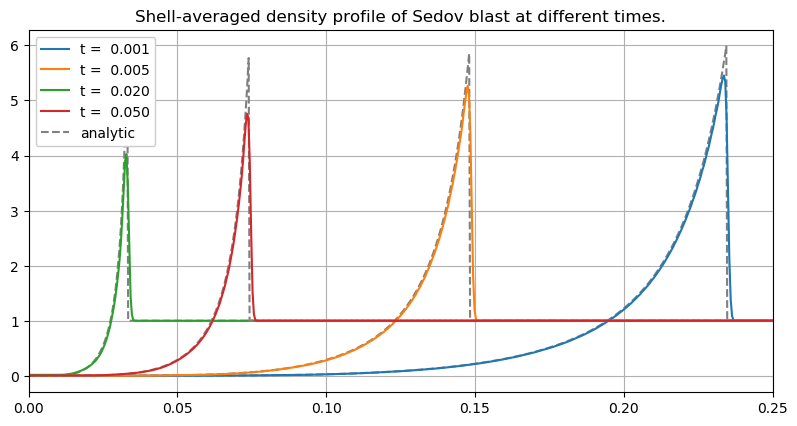

In [13]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.25)
plt.title('Shell-averaged density profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.dens, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.dens, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)

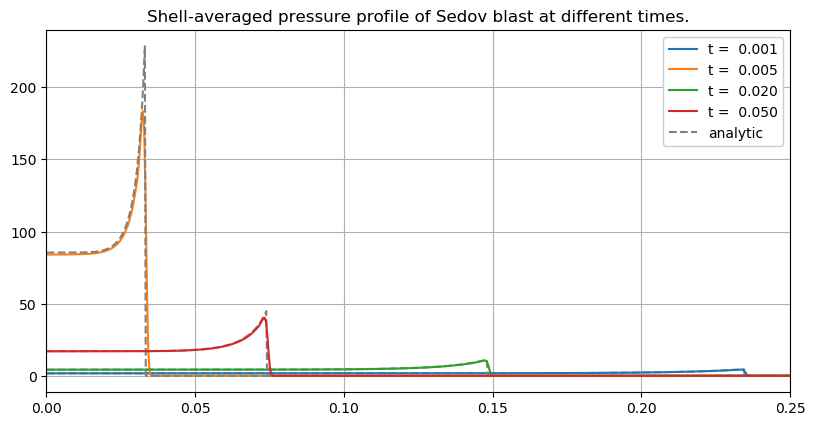

In [11]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.25)
plt.title('Shell-averaged pressure profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.pres, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.pres, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)

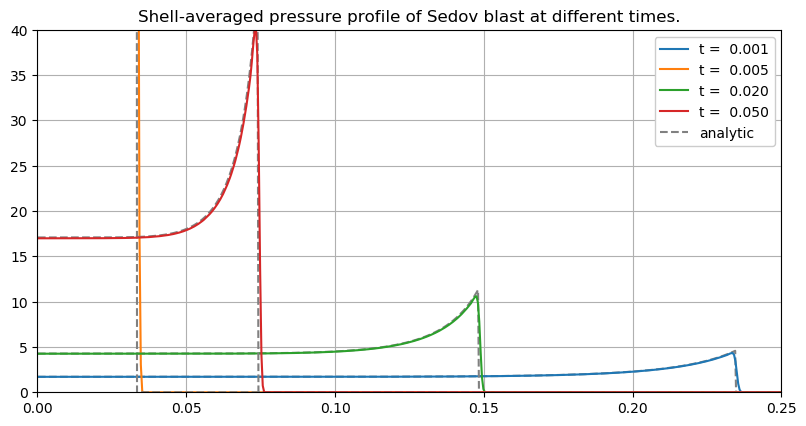

In [12]:
dpi = 100
fig = plt.figure(1,figsize=(1.5*640/dpi, 480/dpi), dpi=dpi)
plt.grid()
plt.xlim(0,0.25)
plt.ylim(0,40)
plt.title('Shell-averaged pressure profile of Sedov blast at different times.')

for ana,num,t in zip(analytics,numerics,[0.001,0.005,0.02,0.05]):
    plt.plot(ana.radius,ana.pres, label='_nolegend_', ls='--',color='gray')
    plt.plot(num.radius,num.pres, label='t = {:6.3f}'.format(t))

plt.plot([],[], label='analytic', ls='--',color='gray')
plt.legend().get_frame().set_alpha(1)